# Figure 2 – Identification of features of highly efficient pegRNAs.
## Figure 2a

Spearman correlations between various features of pegRNA design and correct editing percentage, assessed for all pegRNA-sensor pairs with sufficient reads. Each dot represents a separate replicate/time-point.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [2]:
#first read in information about the library

p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')

#and also information about the editing efficiency of each pegRNA in each time-point and replicate

samples = ['Plasmid-Library', 'D4-REP1', 'D4-REP2', 'D4-REP3',
'D16-REP1', 'D16-REP2', 'D16-REP3',
'D16-NUT-REP1', 'D16-NUT-REP2', 'D16-NUT-REP3',
'D25-REP1', 'D25-REP2', 'D25-REP3',
'D25-NUT-REP1', 'D25-NUT-REP2','D25-NUT-REP3',
'D34-REP1', 'D34-REP2', 'D34-REP3',
'D34-NUT-REP1', 'D34-NUT-REP2', 'D34-NUT-REP3']

crispresso = os.listdir("crispresso/compact_filtered_background_subtracted")

reorder = []
for i in samples:
    for k in crispresso:
        if i in k:
            df = pd.read_csv(f"crispresso/compact_filtered_background_subtracted/{k}")
            reorder.append(df)


cp_dict = dict(zip(samples, reorder))

In [3]:
# and calcualate correlation with pegRNA design parameters

factors = ['RTT_length', 'PBS_length', 'PBS_GC_content', 'distance_to_nick', 'homology_overhang', 'MIT_specificity', 'Doench16_Azimuth_percentile', 'PEGG_score']
col_label = ['sample'] + factors
z = np.zeros(len(samples[1:]))
cols = [samples[1:],z,z,z,z,z,z,z,z]
spear = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')
pearson = pd.DataFrame(dict(zip(col_label,cols))).set_index('sample')

#consider sensors with over 100 sensor reads
count_threshold = 100

for x in samples[1:]:
    df = cp_dict[x]

    #choose a particular variant type if desired
    var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

    chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
    df = df[df['peg_id'].isin(chosen)]

    df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

    p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

    assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

    for factor in factors:
        x1 = np.array(p53_subset[factor])
        y1 = np.array(df['corr_perc_backsub'])

        sr = scipy.stats.spearmanr(x1,y1).statistic
        pr = scipy.stats.pearsonr(x1,y1).statistic

        spear.loc[x, factor]=sr
        pearson.loc[x, factor]=pr

#and plot it
spear_T = spear.T
spear_T['Factor'] = list(spear_T.index)
melted_spear = pd.melt(spear_T, id_vars='Factor')

pearson_T = pearson.T
pearson_T['Factor'] = list(pearson_T.index)
melted_pear = pd.melt(pearson_T, id_vars='Factor')

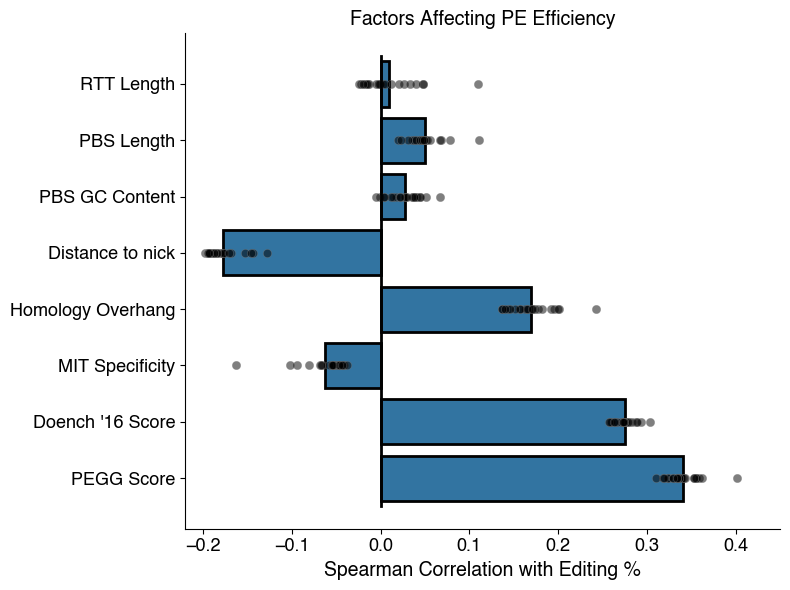

In [24]:
# and plotting
fig, ax = plt.subplots(figsize=(8,6))

g = sns.barplot(data=melted_spear, y='Factor', x='value', ax=ax, linewidth=2, edgecolor='black', palette=['tab:blue'], errorbar=None)
g = sns.scatterplot(data=melted_spear, y='Factor', x='value', ax=ax, color='black', edgecolor='grey', alpha=.5)
#each dot = a separate replicate

ax.plot([0,0], [0-.5,len(factors)-.5], linewidth=2, color='black')

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_title(f"Factors Affecting PE Efficiency", fontsize=14)

ax.set_xlabel("Spearman Correlation with Editing %", fontsize=14)
ax.set_ylabel("")

labs = ['RTT Length', 'PBS Length', 'PBS GC Content', 'Distance to nick', 'Homology Overhang', 'MIT Specificity', "Doench '16 Score", 'PEGG Score']

ax.set_xlim(-.22, .45)
ax.set_yticklabels(labs, rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()


## Figure 2b

The relationship between PEGG score and average correct editing percentage at each time-point & condition is monotonically increasing.

In [3]:
count_threshold=100


avgavg = []
for x in samples[1:]:
    df = cp_dict[x]

    #choose a particular variant type if desired
    var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

    chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
    df = df[df['peg_id'].isin(chosen)]

    df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

    p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

    assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

    x1 = np.array(p53_subset['PEGG_score'])
    y1 = np.array(df['corr_perc_backsub'])



    pegg_bins = [0,.5,1,1.5, 2, 2.5, 3, 3.5, 4]
    avgs = []
    for i in range(0, len(pegg_bins)-1):
        
        y2 = y1[(x1>pegg_bins[i]) & (x1<=(pegg_bins[i+1]))]
        avgs.append(np.average(y2))
    
    avgavg.append(avgs)

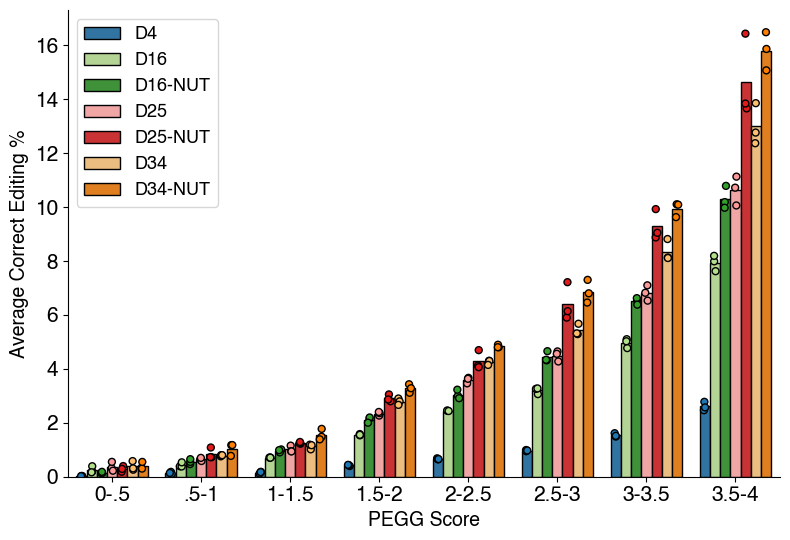

In [7]:
# and plotting
avgavg = np.array(avgavg)

conditions = [i[:-5] for i in samples[1:]]
bb = ['0-.5', '.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4']

dh = []
for i, val in enumerate(samples[1:]):

    a = pd.DataFrame(dict(zip(['sample', 'condition', 'bin', 'edit_avg'], [[val]*8, [conditions[i]]*8, bb, avgavg[i]])))
    dh.append(a)

d_pegg = pd.concat(dh)



from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Paired')
custom_cmap = ListedColormap(cmap(range(1, 9)))
colors = [custom_cmap(i) for i in range(9)]


fig, ax = plt.subplots(figsize=(8,5.5))
g = sns.barplot(data=d_pegg, x='bin', y='edit_avg', hue='condition', ax=ax, linewidth=1, edgecolor='black', errorbar=None, palette=colors)
#NOTE: for some reason, there's an error with categorical hue values for stripplots, unless you use seaborn==0.12.2
g = sns.stripplot(data=d_pegg, x='bin', y='edit_avg', hue='condition', ax=ax, linewidth=1, edgecolor='black', legend=False, dodge=True, palette=colors)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel("Average Correct Editing %", fontsize=14)
ax.set_xlabel("PEGG Score", fontsize=14)
fig.tight_layout()

## Figure 2c

A representative example of the correlation between PEGG score and editing efficiency for Day-25 Replicate 1 (Untreated). Spearman correlation = 0.32; Pearson correlation = 0.21.

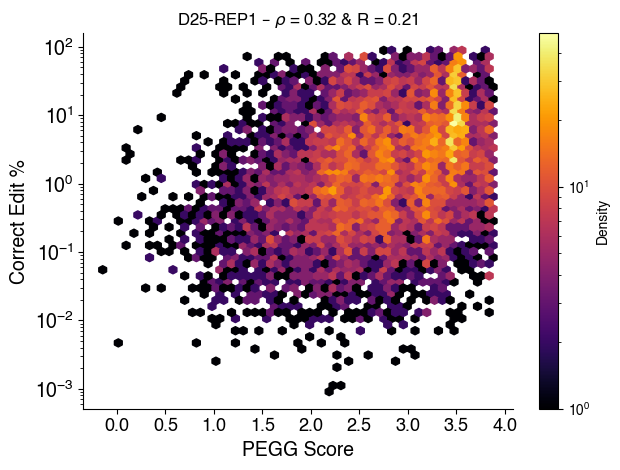

In [27]:
fig, ax1 = plt.subplots()

x='D25-REP1'

df = cp_dict[x]
counts_threshold=100

#choose a particular variant type if desired
var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

x1 = np.array(p53_subset['PEGG_score'])
y1 = np.array(df['corr_perc_backsub'])

sr = scipy.stats.spearmanr(x1,y1).statistic
pr = scipy.stats.pearsonr(x1,y1).statistic


x2 = x1[y1>0]
y2 = y1[y1>0]

hb = ax1.hexbin(x2,y2, gridsize=50,  cmap='inferno', bins='log',yscale="log")

cb = fig.colorbar(hb, ax=ax1, label='Density')

ax1.set_ylabel("Correct Edit %", fontsize=14)
ax1.set_xlabel("PEGG Score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=13)
#ax1.set_xlim(0,)
#ax1.set_ylim(0,)
ax1.set_yscale("log")

ax1.set_title(x + " – "+ r"$\rho$" +  f" = {np.round(sr,2)} & R = {np.round(pr,2)}")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

fig.tight_layout()

## Figure 2d

Visualization of the protospacer bias in editing efficiency. The number of pegRNAs generated per protospacer at each TP53 exon on the plus (+) or minus (-) strand (top) and the average editing efficiency at each of these protospacers at Day 34 of the untreated condition (bottom).

In [37]:
#first assigning a unique index to each protospacer
uniq_protos = np.unique(p53_filtered['protospacer'])
proto_idx_dict = dict(zip(uniq_protos, list(range(len(uniq_protos)))))

#and adding this information to the p53_filtered dataframe
input_df = p53_filtered.copy()
p_idx = []
for i, val in input_df.iterrows():
    p = val['protospacer']
    idx = proto_idx_dict[p]
    p_idx.append(idx)

input_df['unique_proto_idx'] = p_idx

In [40]:
#now forming a dataframe with information about the location of each protospacer

uni = np.unique(input_df['unique_proto_idx'])
num_pegs = np.zeros(len(uni))
strand = []
loc = []
seq = []

for i in uni:
    a = input_df[input_df['unique_proto_idx']==i]
    num_pegs[int(i)]+=len(a)
    strand.append(list(a['PAM_strand'])[0])
    loc.append(list(a['PAM_location'])[0])
    seq.append(list(a['protospacer'])[0])

proto_df = pd.DataFrame(dict(zip(['unique_proto_idx', 'sequence', 'num_pegRNAs', 'strand', 'location'], 
                      [uni, seq, num_pegs, strand, loc])))

proto_df['location_new'] = proto_df['location']-(min(proto_df['location'])-20)
start = []
end = []
for i, val in proto_df.iterrows():
    l = val['location_new']
    s = val['strand']
    if s=='+':
        start.append(l-20)
        end.append(l)
    else:
        end.append(l+21)
        start.append(l+1)

proto_df['start']=start
proto_df['end']=end
proto_df = proto_df.sort_values(by='start')

In [54]:
#reading in correct editing percentages
#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"

reorder = []

conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']

for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))

#and also add in information about the average editing efficiency for pegRNAs with each protospacer
sample = 'D34'
d = cp_dict2[sample]
counts_threshold = 10
d = d[d['Reads_aligned_all_amplicons']>=counts_threshold]

d = pd.merge(d, input_df, on='peg_id')


p=np.zeros(173)
p2 = np.zeros(173)
for i, val in d.iterrows():
    p_id = int(val['unique_proto_idx'])
    p[p_id]+=1
    p2[p_id]+=val['corr_perc_backsub']

s_1 = p2/p
s_1[np.isnan(s_1)]=0

proto_df[sample]=s_1

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_19804/2480838653.py:32: RuntimeWarning: invalid value encountered in divide
  s_1 = p2/p


In [49]:
#writing a function for plotting the number of protospacers or the average editing efficiency of a given protospacer

def proto_viz(samp_name):
    abs_max = max(max(proto_df['end']), max(proto_df['start']))

    c = np.zeros(abs_max)

    plus = [c.copy()]
    minus = [c.copy()]

    for i, val in proto_df.iterrows():
        s = val['start']
        e = val['end']
        strand = val['strand']

        num_pegs = val[samp_name]

        if strand=='+':
            num_rows = len(plus)
            sum1 = []
            for i in range(num_rows):
                sum1.append(sum(plus[i][s:e]))

            open = []
            for k, val2 in enumerate(sum1):
                if val2==0:
                    open.append(k)
                else:
                    continue

            if len(open)==0: #add a new row
                newrow = c.copy()
                newrow[s:e]+=num_pegs
                plus.append(newrow)

            else: #otherwise, add to lowest existing row
                row_to_add = min(open)
                plus[row_to_add][s:e]+=num_pegs


        else: #minus
            num_rows = len(minus)
            sum1 = []
            for i in range(num_rows):
                sum1.append(sum(minus[i][s:e]))

            open = []
            for k, val2 in enumerate(sum1):
                if val2==0:
                    open.append(k)
                else:
                    continue

            if len(open)==0: #add a new row
                newrow = c.copy()
                newrow[s:e]+=num_pegs
                minus.append(newrow)

            else: #otherwise, add to lowest existing row
                row_to_add = min(open)
                minus[row_to_add][s:e]+=num_pegs


    #make them the same size
    for i in range(len(plus)-len(minus)):
        minus.append(c.copy())

    return plus, minus

In [50]:
#taking into account the size of each exon for equal (or close to equal) plotting
#i.e. each base represents an equal size on the plot


#start and end of each CDS/exon in TP53
#accessed from gencodev19.db using gffutils package
#tx = 'ENST00000269305.4'
#cds = list(db.children(tx, order_by='+end', featuretype=['CDS']))
#start_end_cds = [[i.start, i.end] for i in cds]

start_end_cds = np.asarray([[7572930, 7573008],
 [7573927, 7574033],
 [7576853, 7576926],
 [7577019, 7577155],
 [7577499, 7577608],
 [7578177, 7578289],
 [7578371, 7578554],
 [7579312, 7579590],
 [7579700, 7579721],
 [7579839, 7579912]])

bounds = np.asarray(start_end_cds)-(min(proto_df['location'])-20)
bounds[:,1] =bounds[:,1]+40
bounds[:,0] =bounds[:,0]-40
bounds[-1] = [6902, 7010]
wr = [i[1]-i[0] for i in bounds]
wr = [i/max(wr) for i in wr]

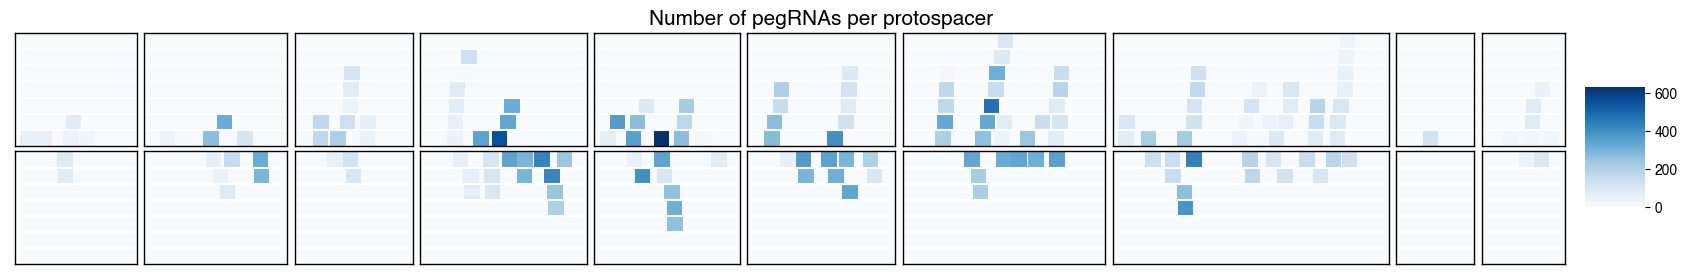

In [58]:
plus, minus = proto_viz('num_pegRNAs')

max_pegs = max(proto_df['num_pegRNAs'])

fig, ax = plt.subplots(2,len(bounds), figsize=(20,3), width_ratios = wr)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, val in enumerate(bounds):
    g = sns.heatmap(plus[::-1], cmap='Blues', ax=ax[0][i], vmax = max_pegs, yticklabels=False, xticklabels=False, cbar=i == 0,cbar_ax=None if i else cbar_ax)
    ax[0][i].hlines(list(range(len(plus)))[1:], *ax[0][i].get_xlim(), color='white')
    ax[0][i].set_xlim(val[0], val[1])

    g2 = sns.heatmap(minus, cmap='Blues', ax=ax[1][i], vmax=max_pegs, cbar=False, yticklabels=False,xticklabels=False)
    ax[1][i].set_xlim(val[0], val[1])
    ax[1][i].hlines(list(range(len(minus)))[1:], *ax[1][i].get_xlim(), color='white')

    for _, spine in g.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    for _, spine in g2.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)

ax[0][5].set_title('Number of pegRNAs per protospacer', fontsize=15)
plt.subplots_adjust(wspace=.05, hspace=.05)

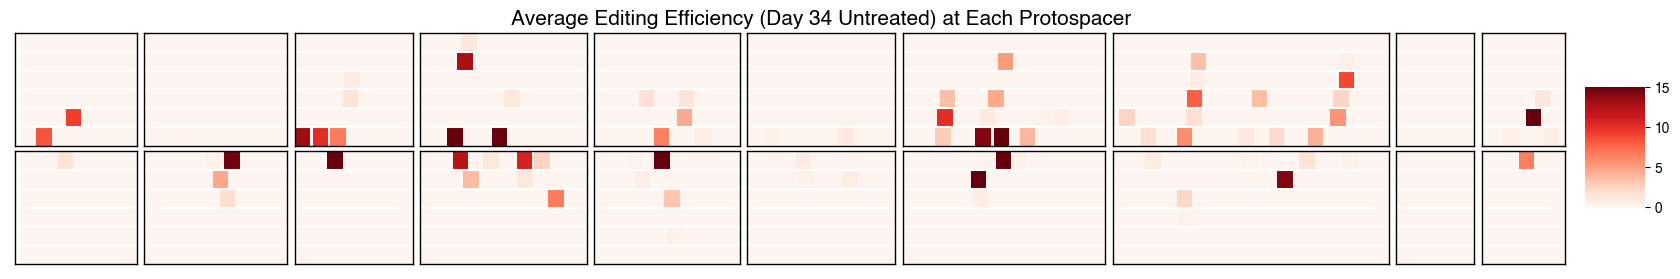

In [60]:
samp_name = 'D34'
plus, minus = proto_viz(samp_name)

max_pegs = max(proto_df[samp_name])
max_pegs=15

fig, ax = plt.subplots(2,len(bounds), figsize=(20,3), width_ratios = wr)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, val in enumerate(bounds):
    g = sns.heatmap(plus[::-1], cmap='Reds', ax=ax[0][i], vmin=0, vmax = max_pegs, yticklabels=False, xticklabels=False, cbar=i == 0,cbar_ax=None if i else cbar_ax)
    ax[0][i].hlines(list(range(len(plus)))[1:], *ax[0][i].get_xlim(), color='white')
    ax[0][i].set_xlim(val[0], val[1])

    g2 = sns.heatmap(minus, cmap='Reds', ax=ax[1][i], vmin=0, vmax=max_pegs, cbar=False, yticklabels=False,xticklabels=False)
    ax[1][i].set_xlim(val[0], val[1])
    ax[1][i].hlines(list(range(len(minus)))[1:], *ax[1][i].get_xlim(), color='white')

    for _, spine in g.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    for _, spine in g2.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)

ax[0][5].set_title('Average Editing Efficiency (Day 34 Untreated) at Each Protospacer', fontsize=15)
plt.subplots_adjust(wspace=.05, hspace=.05)

## Figure 2e

Average editing efficiency for SNV-generating pegRNAs in the library as a function of distance to the nick generated by PEmax and PBS length. The location of the “NGG” PAM sequence is highlighted in blue in the original figure in the manuscript. Protospacer disrupting (locations +1 to +3) and PAM-disrupting variants (locations +5 & +6) tend to be more efficient.

In [7]:
#reading in correct editing percentages
#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"

reorder = []

conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']

for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))

sample = 'D34'
b = cp_dict2[sample]

counts_threshold = 10
b = b[b['Reads_aligned_all_amplicons']>=counts_threshold]

input_df = p53_filtered.copy()

b = pd.merge(b, input_df, on='peg_id')

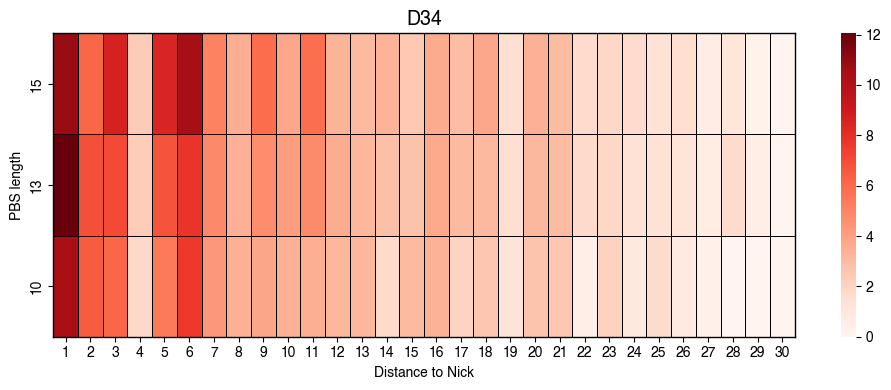

In [10]:
b = b[b['variant_type']=='SNV']

pbs_lens = list(np.unique(b['PBS_length']))

pbs_dict = dict(zip( pbs_lens, [0,1,2]))

#hom_overhang = 
counter = np.zeros((3,30))
perc_holder = np.zeros((3,30))

for k, val in b.iterrows():
    p =val['PBS_length']
    r =val['distance_to_nick']
    p_strand = val['PAM_strand']

    c = val['corr_perc_backsub']
    p_idx = pbs_dict[p]

    counter[p_idx][r-1]+=1
    perc_holder[p_idx][r-1]+=c

perc = perc_holder/counter
perc = perc[::-1]

fig, ax = plt.subplots(figsize=(10,4))
g = sns.heatmap(perc, cmap='Reds', vmin=0, linewidth=.5, linecolor='black')
ax.set_yticklabels(pbs_lens[::-1]);
ax.set_xticklabels(list(range(1,31)));
ax.set_xlabel("Distance to Nick")
ax.set_ylabel("PBS length")
ax.set_title(sample, fontsize=14)

for _, spine in g.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)

fig.tight_layout()

## Figure 2f

 Feature importances of 20 Random Forest models separately trained to predict pegRNA efficiency. Each dot represents a different model. 


In [7]:
x = 'D16-REP1'
df = cp_dict[x] #see code above (Figure 2a for cp_dict assignment)

count_threshold=100

#choose a particular variant type if desired
var_types = ['SNV', 'INS', 'DEL', 'ONV'] #['SNP']

chosen = list(p53_filtered[p53_filtered['variant_type'].isin(var_types)]['peg_id'])
df = df[df['peg_id'].isin(chosen)]

df = df[df['Reads_aligned_all_amplicons']>=count_threshold]

p53_subset = p53_filtered[p53_filtered['peg_id'].isin(list(df['peg_id']))]

#would be easier to just merge these dataframes (functionally the same when indexing is identical like this though)
assert list(p53_subset['peg_id'])==list(df['peg_id']) #ensure indexing is correct

b = p53_subset

In [8]:
#training of the model
from sklearn.ensemble import RandomForestRegressor # for building the model

def model_training():
    #converting PAM sequences and variant types to integers for training
    PAM_dict = {"AGG":0, 'GGG':1, 'CGG':2, 'TGG':3}
    num_PAM = [PAM_dict[k] for k in b['PAM']]
    b['num_PAM'] = num_PAM

    var_dict = {"SNV":0, 'INS':1, 'DEL':2, 'ONV':3}
    num_var = [var_dict[k] for k in b['variant_type']]
    b['var_type'] = num_var

    #adding in correct percentage
    b['corr_perc'] = df['corr_perc_backsub']

    #train, test splitting; ensuring same variant isn't in train and test
    uniq_DNA = np.unique(b['HGVSc'])
    perc_train = .7
    num_train = int(perc_train*len(uniq_DNA))

    train_set = list(np.random.choice(uniq_DNA, size=num_train, replace=False))

    train = b[b['HGVSc'].isin(train_set)]
    test =b[~b['HGVSc'].isin(train_set)]

    X_train = np.array(train[["PBS_length", "Doench16_Azimuth_percentile", "PBS_GC_content", "homology_overhang","distance_to_nick", "RTT_length", "num_PAM", "var_type"]])
    Y_train = np.array(train[["corr_perc"]])

    X_test = np.array(test[["PBS_length", "Doench16_Azimuth_percentile", "PBS_GC_content", "homology_overhang","distance_to_nick", "RTT_length", "num_PAM", "var_type"]])
    Y_test = np.array(test[["corr_perc"]])

    # Initializing the Random Forest Regression model with 1000 decision trees
    model = RandomForestRegressor(n_estimators = 1000, random_state = 0)

    # Fitting the Random Forest Regression model to the data
    model.fit(X_train, Y_train)

    return model


In [9]:
#and now run the model 20 times and see what the top feature importances are 
#this will take a couple minutes to run (~30 seconds/model * 20 models)
aaa = []
for i in range(20):

    model = model_training()

    importances = model.feature_importances_

    features = ["PBS length", "Doench '16 Score", "PBS GC content", "Homology Overhang","Distance to nick", "RTT length", "PAM", "Variant Type"]

    aa = pd.DataFrame(dict(zip(['Feature', 'Importance'], [features, importances])))
    aaa.append(aa)

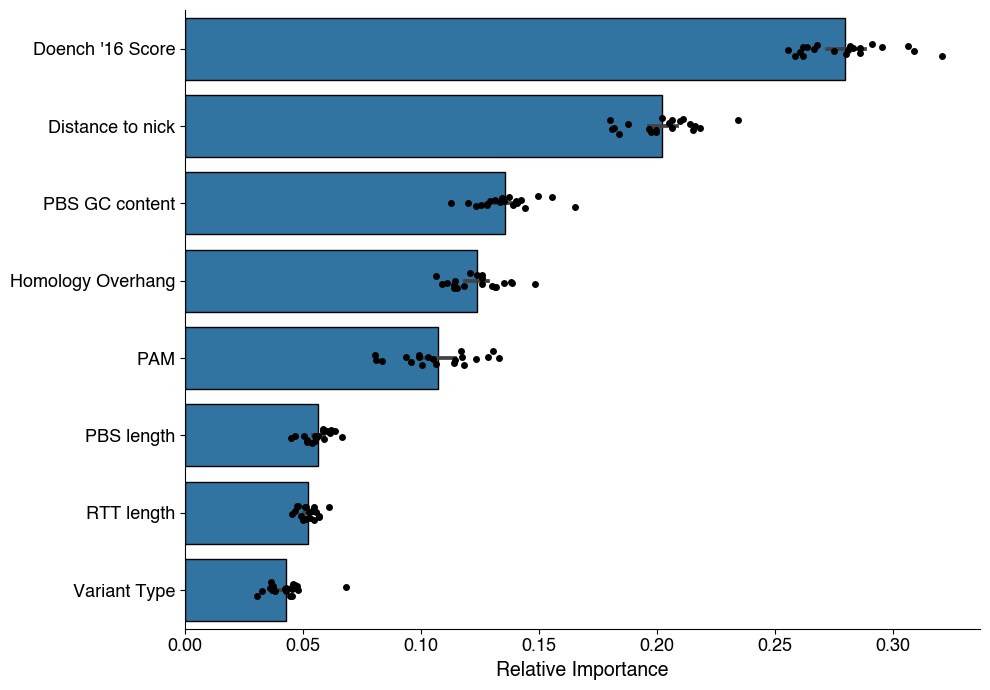

In [76]:
#and finally plotting
#there will be subtle differences each time this is run because of the random nature of model training/variability among models
con = pd.concat(aaa)
fig, ax = plt.subplots(figsize=(10,7))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
order = ["Doench '16 Score", 'Distance to nick', 'PBS GC content', 'Homology Overhang', 'PAM', 'PBS length', 'RTT length', 'Variant Type']
sns.barplot(data=con, x='Importance', y='Feature', color='tab:blue', order = order, linewidth=1, edgecolor='black',ax=ax)
sns.stripplot(data=con, x='Importance', y='Feature', color='black', order=order, edgecolor='black', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel("Relative Importance", fontsize=14)
ax.set_ylabel("")
fig.tight_layout()